<a href="https://colab.research.google.com/github/tbeers615/DeepLearningProjects/blob/SkimLit/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 📑🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

📖 **Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm Access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5f5d3592-d121-c466-30ff-64d44635e756)


## Get Data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

## Preprocess Data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...
> Visualize, visualize, visualize...

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [ ]:
# Creat function to read the lines of a document
def get_lines(filename):
  """
  Reads filename  (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # Read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number' : 0,
   'target' : 'BACKGROUND',
   'text' : 'Emotional eating is associated with overeating and the development of obesity.\n'
   'total_lines': 11},
   ...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries line data.

  Takes in filename, reads its contents, and sorts through each line, extracting
  things like the target label, the text of the sentence, how many sentences
  are in the current abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # Get all lines from file
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # Create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #Check to see if this line is an ID line
      abstract_id = line
      abstract_lines = "" # Reset the abstract string if the line is an ID line
    elif line.isspace() : # Check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # Split abstract into separate lines


      # Iterate through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # Split target label from text
        line_data["target"] = target_text_split[0] # Get target label
        line_data["text"] = target_text_split[1].lower() # Get target text and lower it
        line_data["line_number"] = abstract_line_number # What number the line appears in abstract
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data) # Add line data to abstract samples list

    else: # If the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 416 ms, sys: 97.2 ms, total: 513 ms
Wall time: 509 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

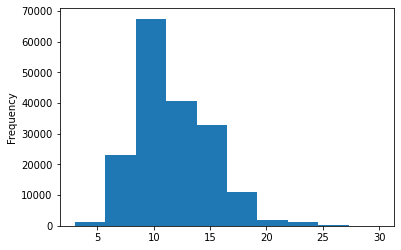

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get Lists of Sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make Numeric Labels (ML Models Require Numeric Labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label Encode Labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes = class_names

### Starting a Series of Modelling Experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And, as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Baseline Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert words into numbers
    ("clf", MultinomialNB()) # Model the text
])

# Fit
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the base model
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy of {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of 72.18%


In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download our helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall, and f1) and rather than rewriting it here let's download it.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-25 13:45:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-25 13:45:16 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results, create_tensorboard_callback

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Reminder: typical structure of a Conv1D model for sequences (in this case it's text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities
```

In [ ]:
import numpy as np
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

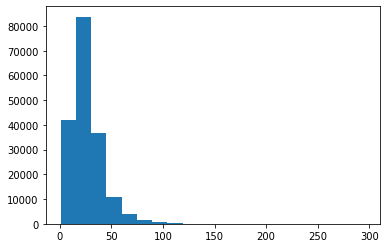

In [ ]:
# What's the distribution?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

### Create Text Vectorizer Layer
We want to make a layer which maps our words to numbers.

In [ ]:
# How many words are in our vocabulary? (Taken from Table 2 in the SkimLit paper)
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len)  # 95% of all sentences are less than 55 words

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
we compared the two techniques .

Length of text: 32

Vectorized text: [[ 43  34   2  51 824   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [ ]:
# How many words in our training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Create Custom Text Embedding

In [ ]:
from keras import layers

# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim = 128, # Note: different embedding sizes result in drastically different number of values to train
                             mask_zero = True, # Use masking to handle variable sequence length
                             name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 we compared the two techniques .

Sentence after vectorization (before embedding):
[[ 43  34   2  51 824   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
[[[ 0.0274825   0.04121098 -0.01924071 ... -0.03919678 -0.03823673
    0.03753142]
  [ 0.02364984 -0.04059217  0.03035736 ... -0.00453616  0.04622552
    0.01913985]
  [ 0.02456849  0.0161687  -0.03135769 ... -0.04780639 -0.00971671
    0.02027165]
  ...
  [ 0.03768594  0.01356358 -0.02584792 ... -0.00710908 -0.00507058
   -0.01004479]
  [ 0.03768594  0.01356358 -0.02584792 ... -0.00710908 -0.00507058
   -0.01004479]
  [ 0.03768594  0.01356358 -0.02584792 ... -0.00710908 -0.00507058
   -0.01004479]]]

Embedded sentence shape: (1, 55, 128)


## Creating Datasets (Making sure our data loads as quickly as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed in the following two resources:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
import tensorflow as tf

# Turn out data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDatasets and turn the into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
from keras import layers
conv1d = layers.Conv1D(filters = 32,
                       kernel_size = 5,
                       activation = "relu",
                       padding="valid")
max_pool = layers.GlobalMaxPool1D()

## Model 1: Conv1D With Token Embeddings

In [ ]:
num_classes = len(label_encoder.classes_)

In [ ]:
# Conv1D to process sequences
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters=64,kernel_size=5,activation="relu",padding="same")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector from conv1d layer
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 18 kB/s 
     |████████████████████████████████| 462 kB 4.7 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (59.8 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

In [ ]:
# Fit the model

SAVE_DIR = "model_logs"

model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 19s 16ms/step - loss: 0.9219 - accuracy: 0.6320 - val_loss: 0.6889 - val_accuracy: 0.7360
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.6624 - accuracy: 0.7542 - val_loss: 0.6337 - val_accuracy: 0.7680
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6243 - accuracy: 0.7723 - val_loss: 0.6016 - val_accuracy: 0.7859
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5951 - accuracy: 0.7861 - val_loss: 0.5824 - val_accuracy: 0.7869
Epoch 5/5
562/562 [==============================] - 5s 10ms/step - loss: 0.5930 - accuracy: 0.7919 - val_loss: 0.5634 - val_accuracy: 0.8039


In [ ]:
# Get the weight matrix of embedding layer
# These are the numberical representations of each token in our training data, which have been learned for 5 epochs
embed_weights = model_1.get_layer("token_embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding dim

(64841, 128)


In [ ]:
# Get the vocabulary from the text vectorization layer
vocab = text_vectorizer.get_vocabulary()

In [ ]:
len(vocab)

64841

In [ ]:
# Create embedding files (from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv','w',encoding='utf-8')
out_m = io.open('metadata.tsv','w',encoding='utf-8')

for index, word in enumerate(vocab[63000:]):
  if index == 0:
    continue # skip 0, it's padding
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5599 - accuracy: 0.8016


[0.5599086284637451, 0.8015689253807068]

In [ ]:
# Make predictions (our model predicts prediction probabilites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

In [ ]:
# Convert pred probs to clases
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

In [ ]:
# Calculate model_1_results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

In [ ]:
baseline_results

## Model 2: Feature Extraction With Pretrained Token Embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally use GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
the efficacy and safety of insulin degludec ( ideg ) was compared with insulin detemir ( idet ) , both administered once daily ( od ) as basal treatment in participants with type @ diabetes mellitus ( t@dm ) .
Sentence after embedding:
[-0.02726428 -0.02281957 -0.03678939 -0.01608411 -0.0439023  -0.04420625
  0.02533899  0.03972175  0.05224708  0.04490607  0.0780699  -0.02379275
  0.03626882  0.04789417 -0.06538554 -0.03900418 -0.07812476  0.02241246
 -0.07430709  0.05253841  0.00384984  0.02645904  0.02095775  0.01110277
  0.07447381  0.04330146  0.0478725   0.06198653 -0.02966512 -0.05797296]
Length of sentence embedding: 512


## Building and Fitting an NLP Feature Extraction Model Using Pretrained Embeddings TensorFlow Hub

In [ ]:
inputs = layers.Input(shape=[],dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding) # Condense the output of our feature vector from conv1d layer
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

In [ ]:
# Convert the prediction probabilities with feature extraction model
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

In [ ]:
# Calculate results from TF Hub pretrained embeddings result on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

In [ ]:
baseline_results

## Model 3: Conv1D With Character Embeddings
The paper which we're replicating states that they used a combination of token and character-level embeddings.

Previously we've used token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character level sequences into characters
#split_chars(random_train_sentence)

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

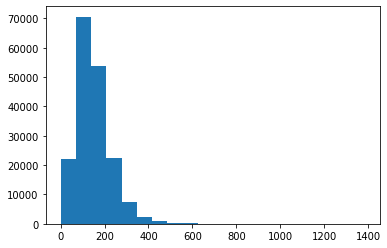

In [ ]:
# Check the distribution of our sequences
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20)

In [ ]:
# Find what character length characters 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # Add 2 for space and 00v token (OOV out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 r o o t   r e p l a c e m e n t   m a n a g e m e n t   d i d   n o t   i n c r e a s e   h o s p i t a l   m o r t a l i t y   (   p r o p e n s i t y   s c o r e - a d j u s t e d   o d d s   r a t i o   ,   @   ;   p   =   @   )   .
Length of random_train_chars: 98

Vectorized chars:
 [[ 8  7  7  3  8  2 14 12  5 11  2 15  2  6  3 15  5  6  5 18  2 15  2  6
   3 10  4 10  6  7  3  4  6 11  8  2  5  9  2 13  7  9 14  4  3  5 12 15
   7  8  3  5 12  4  3 19 14  8  7 14  2  6  9  4  3 19  9 11  7  8  2  5
  10 27 16  9  3  2 10  7 10 10  9  8  5  3  4  7 14  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0

## Creating a Character-Level Embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed") # Number of different characters



In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 r o o t   r e p l a c e m e n t   m a n a g e m e n t   d i d   n o t   i n c r e a s e   h o s p i t a l   m o r t a l i t y   (   p r o p e n s i t y   s c o r e - a d j u s t e d   o d d s   r a t i o   ,   @   ;   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[ 0.00118632  0.0277563   0.04606715 ...  0.02546812  0.03798214
   -0.0198678 ]
  [-0.01783045  0.02185393 -0.03136005 ... -0.02757037 -0.03726862
    0.02303228]
  [-0.01783045  0.02185393 -0.03136005 ... -0.02757037 -0.03726862
    0.02303228]
  ...
  [-0.03768941  0.00563905  0.0392076  ...  0.03891791 -0.01140682
    0.00831557]
  [-0.03768941  0.00563905  0.0392076  ...  0.03891791 -0.01140682
    0.00831557]
  [-0.03768941  0.00563905  0.0392076  ...  0.03891791 -0.01140682
    0.00831557]]]

Character embedding shape: (1, 290, 25)


In [ ]:
len(random_train_chars)

569

## Model 3: Conv1D With Character Embeddings

In [ ]:
# Conv1D to process sequences
inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_vectorizer(inputs) # vectorize text inputs
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters=64,kernel_size=100,activation="relu",padding="same")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x) # Condense the output of our feature vector from conv1d layer
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs)

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit model_3 to the data
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

In [ ]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

In [ ]:
# Calculate results
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

## Model 4: Combining Pretrained Token Embeddings with Character Embeddings (Hybrid Embedding Layer)

1. Create a token-level embedding model (similiar to `model_1`)
2. Create a character-level embedding model (similiar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.concatenate`)
4. Build a series of output layers on top of #3 (similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as outputs

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs=char_bi_lstm)

# 3. Combine 1 and 2 with concatenate (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout (discussed in section 4.2 of paper)
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Construct model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="Model_4_Token_and_Char_Embeddings")

model_4.summary()

NameError: ignored

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [ ]:
# Create hybrid level datasets
train_hybrid_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_data,train_hybrid_labels))

# Prefetch and batch train data
train_hybrid_dataset = train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_hybrid_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_hybrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_hybrid_dataset = tf.data.Dataset.zip((test_hybrid_data,test_hybrid_labels))

# Prefetch and batch test data
test_hybrid_dataset = test_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_hybrid_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_hybrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_hybrid_dataset = tf.data.Dataset.zip((val_hybrid_data,val_hybrid_labels))

# Prefetch and batch validation data
val_hybrid_dataset = val_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Compile token char model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fit model_4 to the data
history_model_4 = model_4.fit(train_hybrid_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1*len(train_hybrid_dataset)),
                              validation_data=val_hybrid_dataset,
                              validation_steps = int(0.1 * len(val_hybrid_dataset)))

In [ ]:
# Evaluate model
model_4.evaluate(val_hybrid_dataset)

In [ ]:
# Make predictions with hybrid model
model_4_pred_probs = model_4.predict(val_hybrid_dataset)
model_4_pred_probs

In [ ]:
# Convert prediction probabilities to class labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [ ]:
# Calculate results
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

In [ ]:
baseline_results

In [ ]:
model_1_results

In [ ]:
model_2_results

In [ ]:
model_3_results

## Model 5: Transfer Learning With Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

In [ ]:
train_df.head()

> 🔑 **Note**: Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create Positional Embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
# Check the distribution of "line number" column
train_df.line_number.plot.hist()

In [ ]:
# 95% percentile of line numbers

line_number_95 = int(np.percentile(train_df.line_number, 95))
line_number_95

13

In [ ]:
sum(train_df["line_number"].value_counts())

180040

In [ ]:
sum(train_df["line_number"].value_counts()[:14]) / sum(train_df["line_number"].value_counts())

0.9566929571206398

In [ ]:
# Use TensorFlow to create one-hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

Now that we've encoded our line numbers feature, let's do the same for our total lines feature...

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

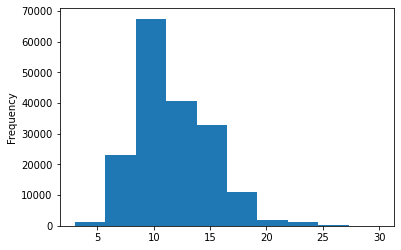

In [ ]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot.shape, val_total_lines_one_hot[:10]

(TensorShape([30212, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.,

### Building a tribrid embedding model
1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine 3, 4, & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, and 4 and outputs of 7 into a tf.keras.Model

In [ ]:
test_total_lines_one_hot.shape

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype="string",name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Create a model for line number
line_num_inputs = layers.Input(shape=(15,),dtype=tf.float32,name="num_line_inputs")
x = layers.Dense(32,activation="relu")(line_num_inputs)
line_num_model = tf.keras.Model(inputs=line_num_inputs,
                                outputs=x)

# 4. Create a model for total lines
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name="total_line_inputs")
y = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

# 5b.
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with comvined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_num_model.output,
                                                                                total_lines_model.output,
                                                                                z])
# 7. Create output layer
output_layer = layers.Dense(5,activation="softmax",name="output_layer")(tribrid_embeddings)

# 8. Put together with all inputs
model_5 = tf.keras.Model(inputs=[line_num_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="Model_5_Tribrid_Embedding_Model")


In [ ]:
# Get a summary of our tribrid embedding model
model_5.summary()

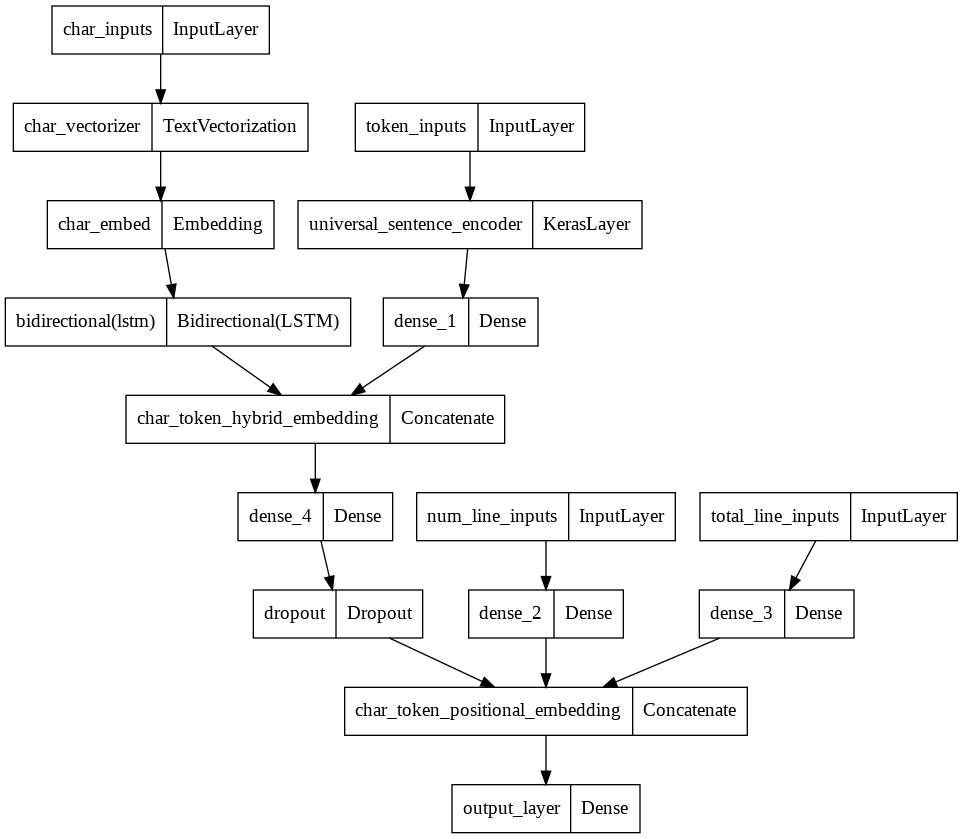

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot tribrid model
plot_model(model_5)

What is label smoothing?

If our model gets too confident on a single class (e.g. its prediction probability is quite high) it may get stuck on that class and not consider other classes.

Highly confident: `[0.0, 0.0, 1.0, 0.0]`

What label smoothing does is it assigns some of the value from the most confident/highest prediction probability to other classes, in turn improving generalization (hopefully): `[0.14, 0.08, 0.75, 0.02, 0.01]`

In [ ]:
# Compile the token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create Tribrid Embedding Datasets using tf.data

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels)) # combine data and labels
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, # line numbers
                                                              val_total_lines_one_hot, # total lines
                                                              val_sentences,
                                                              val_chars)) # train chars
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # train labels
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels)) # combine data and labels
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_tribrid_dataset, val_tribrid_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting, Evaluating, and Making Predictions With Our Tribrid Model

In [ ]:
import tensorflow as tf

# Fit model_5 to the data
history_model_5 = model_5.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1*len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps = int(0.1*len(val_tribrid_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 43s 51ms/step - loss: 1.1012 - accuracy: 0.7200 - val_loss: 0.9850 - val_accuracy: 0.8049
Epoch 2/3
562/562 [==============================] - 26s 47ms/step - loss: 0.9687 - accuracy: 0.8159 - val_loss: 0.9509 - val_accuracy: 0.8245
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.9503 - accuracy: 0.8227 - val_loss: 0.9401 - val_accuracy: 0.8314


In [ ]:
# Evaluate model 5
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 23s 25ms/step - loss: 0.9381 - accuracy: 0.8316


[0.938113272190094, 0.8315901160240173]

In [ ]:
test_abstract_two = "The global prevalence of obesity has significantly increased in most industrialized countries. Anti-obesity drugs are scarce, and indications to change their life style are impractical. Therefore, to identify diets able to produce significantly and maintained weight loss is mandatory. The present work evaluated the efficacy of a very low-calorie-ketogenic (VLCK) diet in obesity. A group of obese patients were randomized into two groups: the VLCK diet group and a standard low-calorie diet (LC group). The follow-up period was 12 months. Both groups received external support, counseling, to perform physical activity and adhered to the diet. The VLCK diet induced a 30-45 days of mild ketosis and significant effects on body weight within 15 days. At 2 months, the weight reductions in the VLCK diet and LC diet groups were 13.6 ± 3.9 and 4.8 ± 2.7 kg, respectively (p < 0.0001). At the end of the study, at 12 months, the weight reductions were 19.9 ± 12.3 and 7.0 ± 5.6 kg, respectively (p < 0.0001), and more than 88 % of patients in the VLCK diet group lost more of 10 % of their initial weight. Lean mass was practically unaffected. The VLCK diet was well tolerated and the side effects were moderate and transitory. In a group of obese patients, the VLCK diet was significantly more effective than a standard LC diet. At one year follow-up in the group with VLCK diet, most of the patients loss more than 10 % of their initial weight and lean mass was well preserved."

In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe("sentencizer") # add sentence splitting pipeline object to sentence parser
doc = nlp(test_abstract_two) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['The global prevalence of obesity has significantly increased in most industrialized countries.',
 'Anti-obesity drugs are scarce, and indications to change their life style are impractical.',
 'Therefore, to identify diets able to produce significantly and maintained weight loss is mandatory.',
 'The present work evaluated the efficacy of a very low-calorie-ketogenic (VLCK) diet in obesity.',
 'A group of obese patients were randomized into two groups: the VLCK diet group and a standard low-calorie diet (LC group).',
 'The follow-up period was 12 months.',
 'Both groups received external support, counseling, to perform physical activity and adhered to the diet.',
 'The VLCK diet induced a 30-45 days of mild ketosis and significant effects on body weight within 15 days.',
 'At 2 months, the weight reductions in the VLCK diet and LC diet groups were 13.6 ± 3.9 and 4.8 ± 2.7 kg, respectively (p < 0.0001).',
 'At the end of the study, at 12 months, the weight reductions were 19.9 ± 12.3 

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'The global prevalence of obesity has significantly increased in most industrialized countries.',
  'line_number': 0,
  'total_lines': 13},
 {'text': 'Anti-obesity drugs are scarce, and indications to change their life style are impractical.',
  'line_number': 1,
  'total_lines': 13},
 {'text': 'Therefore, to identify diets able to produce significantly and maintained weight loss is mandatory.',
  'line_number': 2,
  'total_lines': 13},
 {'text': 'The present work evaluated the efficacy of a very low-calorie-ketogenic (VLCK) diet in obesity.',
  'line_number': 3,
  'total_lines': 13},
 {'text': 'A group of obese patients were randomized into two groups: the VLCK diet group and a standard low-calorie diet (LC group).',
  'line_number': 4,
  'total_lines': 13},
 {'text': 'The follow-up period was 12 months.',
  'line_number': 5,
  'total_lines': 13},
 {'text': 'Both groups received external support, counseling, to perform physical activity and adhered to the diet.',
  'line_num

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(14, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
     

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h e   g l o b a l   p r e v a l e n c e   o f   o b e s i t y   h a s   s i g n i f i c a n t l y   i n c r e a s e d   i n   m o s t   i n d u s t r i a l i z e d   c o u n t r i e s .',
 'A n t i - o b e s i t y   d r u g s   a r e   s c a r c e ,   a n d   i n d i c a t i o n s   t o   c h a n g e   t h e i r   l i f e   s t y l e   a r e   i m p r a c t i c a l .',
 'T h e r e f o r e ,   t o   i d e n t i f y   d i e t s   a b l e   t o   p r o d u c e   s i g n i f i c a n t l y   a n d   m a i n t a i n e d   w e i g h t   l o s s   i s   m a n d a t o r y .',
 'T h e   p r e s e n t   w o r k   e v a l u a t e d   t h e   e f f i c a c y   o f   a   v e r y   l o w - c a l o r i e - k e t o g e n i c   ( V L C K )   d i e t   i n   o b e s i t y .',
 'A   g r o u p   o f   o b e s e   p a t i e n t s   w e r e   r a n d o m i z e d   i n t o   t w o   g r o u p s :   t h e   V L C K   d i e t   g r o u p   a n d   a   s t a n d a r d   l o w - c a l o r i e   d i e t   ( L 

In [ ]:
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))

In [ ]:
abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
abstract_preds

<tf.Tensor: shape=(14,), dtype=int64, numpy=array([0, 0, 0, 0, 2, 2, 2, 1, 4, 4, 4, 4, 1, 4])>

In [ ]:
abstract_pred_classes = [label_encoder.classes_[i].title() for i in abstract_preds]
abstract_pred_classes

['Background',
 'Background',
 'Background',
 'Background',
 'Methods',
 'Methods',
 'Methods',
 'Conclusions',
 'Results',
 'Results',
 'Results',
 'Results',
 'Conclusions',
 'Results']

In [ ]:
# Append the predicted labels with the lines from the abstract
for i, line in enumerate(abstract_lines):
  if abstract_pred_classes[i] == abstract_pred_classes[i - 1]:
    print(f"{line}")
  else:
    print(f"\n{abstract_pred_classes[i]}\n {line}")


Background
 The major metabolic complications of obesity and type 2 diabetes may be prevented and managed with dietary modification.
The use of sweeteners that provide little or no calories may help to achieve this objective.
We did a systematic review and network meta-analysis of the comparative effectiveness of sweetener additives using Bayesian techniques.

Methods
 MEDLINE, EMBASE, CENTRAL and CAB Global were searched to January 2011.
Randomized trials comparing sweeteners in obese, diabetic, and healthy populations were selected.
Outcomes of interest included weight change, energy intake, lipids, glycated hemoglobin, markers of insulin resistance and glycemic response.
Evidence-based items potentially indicating risk of bias were assessed.

Results
 Of 3,666 citations, we identified 53 eligible randomized controlled trials with 1,126 participants.
In diabetic participants, fructose reduced 2-hour blood glucose concentrations by 4.81 mmol/L (95% CI 3.29, 6.34) compared to glucose.

In [ ]:
# Predictions
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_pred_probs

In [ ]:
# Convert to labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

In [ ]:
# Calculate results
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

In [ ]:
# Put all results into a dataframe
all_model_results = pd.DataFrame({
    "model_0_baseline": baseline_results,
    "model_1_custom_token_embedding": model_1_results,
    "model_2_pretrained_token_embedding": model_2_results,
    "model_3_custom_char_embedding": model_3_results,
    "model_4_hybrid_char_token_embedding": model_4_results,
    "model_5_tribrid_embedding": model_5_results
})
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
# Reduce accuracy to use the same scale
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

## Save and Load Model

In [ ]:
# Save best performing model
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with loaded model
loaded_pred_probs = loaded_model.predict(val_tribrid_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [ ]:
# Calculate results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

## Download and load in a pretrained model from Google Storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

In [ ]:
# Load in model
loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")